In [1]:
# !pip3 uninstall spacy==2.2.2
# !python3 -m spacy download en_core_web_sm
# !pip3 install beautifulsoup4
# !pip3 install textblob
# !pip3 install text_hammer

In [2]:
# import spacy
# spacy.load('en_core_web_sm')

In [3]:
# !/usr/bin/python3.6 -m pip install --upgrade pip

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## MultiClass classification by using SOTA BERT model and then fine tuning on Tensorflow 
1. ### We will use tokenizer
2. ### We will convert our data in the form of BERT 
3. ### We will see how to use pretrained BERT architecture 
4. ### We will then finetune the bert model
5. ### Model evaluation 


Author @ Abhishek jaiswal (kaggle @ https://www.kaggle.com/preatcher)


In [5]:
import pandas as pd
import numpy as np
import text_hammer as th
import os

2023-03-13 02:10:37.926757: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 02:10:38.055479: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-13 02:10:38.085316: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-13 02:10:38.554502: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [6]:
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False # if autocompletion doesnot work in kaggle notebook | hit tab

In [7]:
# importing the dataset 
df_train = pd.read_csv('DataSet/train_data.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_test = pd.read_csv('DataSet/test_data.txt', header = None, sep =';', names = ['Input','Sentiment'],encoding='utf-8')
df_val=pd.read_csv('DataSet/val_data.txt', header=None,sep=';',names=['Input','Sentiment'],encoding='utf-8')

In [8]:
df_full = pd.concat([df_train,df_test,df_val], axis = 0)
df_full

,Input,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness
1996,i constantly worry about their fight against n...,joy
1997,i feel its important to share this info for th...,joy
1998,i truly feel that if you are passionate enough...,joy


#### here we are doing some text preprocessing 



In [9]:
%%time

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

from tqdm.notebook import tqdm
tqdm.pandas()

def text_preprocessing(df,col_name):
    print("@text_preprocessing")
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
#     df[column] = df[column].progress_apply(lambda x: ps.remove_stopwords(x))

    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
#     df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return df

CPU times: user 871 µs, sys: 0 ns, total: 871 µs
Wall time: 746 µs


In [10]:
# df_cleaned = text_preprocessing(df_full,'Input')

In [11]:
# df_cleaned = df_cleaned.copy()
df_cleaned = df_full

In [12]:
df_cleaned['num_words'] = df_cleaned.Input.apply(lambda x:len(x.split()))

In [13]:
# changing the data type to the category to encode into codes 
df_cleaned['Sentiment'] = df_cleaned.Sentiment.astype('category')


In [14]:
df_cleaned.Sentiment

0       sadness
1       sadness
2         anger
3          love
4         anger
         ...   
1995    sadness
1996        joy
1997        joy
1998        joy
1999        joy
Name: Sentiment, Length: 20000, dtype: category
Categories (6, object): ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

In [15]:
df_cleaned.Sentiment.cat.codes

0       4
1       4
2       0
3       3
4       0
       ..
1995    4
1996    2
1997    2
1998    2
1999    2
Length: 20000, dtype: int8

In [16]:
encoded_dict  = {'anger':0,'fear':1, 'joy':2, 'love':3, 'sadness':4, 'surprise':5}

In [17]:
df_cleaned['Sentiment']  =  df_cleaned.Sentiment.cat.codes
df_cleaned.Sentiment

0       4
1       4
2       0
3       3
4       0
       ..
1995    4
1996    2
1997    2
1998    2
1999    2
Name: Sentiment, Length: 20000, dtype: int8

In [18]:
df_cleaned.num_words.max()

66

In [19]:
from sklearn.model_selection import train_test_split
data_train,data_test = train_test_split(df_cleaned, test_size = 0.3, random_state = 42, stratify = df_cleaned.Sentiment)

In [20]:
data_train.shape

(14000, 3)

In [21]:
data_test.shape

(6000, 3)

In [22]:
from tensorflow.keras.utils import to_categorical

In [23]:
to_categorical(data_train.Sentiment)

array([[0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

### so far we have cleaned our text data now we need to encode our output in some labels , 
here we have two method to encode 

## Now lets load the model 

In [24]:
from transformers import AutoTokenizer,TFBertModel
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

2023-03-13 02:10:41.856742: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 02:10:44.560624: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 73213 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:17:00.0, compute capability: 8.0
2023-03-13 02:10:44.561853: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 75335 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:65:00.0, compute capability: 8.0
2023-03-13 02:10:46.094560: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the

In [25]:
tokenizer.save_pretrained('bert-tokenizer')
bert.save_pretrained('bert-model')
# for saving model locally and we can load it later on

In [26]:
import shutil
shutil.make_archive('bert-tokenizer', 'zip', 'bert-tokenizer')

'/home/siu856533724/code/pc114/Social-Networks/Trend-Prediction/bert-tokenizer.zip'

In [27]:
shutil.make_archive('bert-model','zip','bert-model')

'/home/siu856533724/code/pc114/Social-Networks/Trend-Prediction/bert-model.zip'

In [28]:
### we can use distilbert its lighter cheaper and similar performance 

from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [29]:
tokenizer('hello this me abhishek')

{'input_ids': [101, 19082, 1142, 1143, 170, 1830, 27516, 4638, 1377, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [30]:
# Tokenize the input (takes some time) 
# here tokenizer using from bert-base-cased
x_train = tokenizer(
    text=data_train.Input.tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


x_test = tokenizer(
    text=data_test.Input.tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)



In [31]:
x_test['input_ids']

<tf.Tensor: shape=(6000, 70), dtype=int32, numpy=
array([[ 101,  178, 1474, ...,    0,    0,    0],
       [ 101,  178, 1631, ...,    0,    0,    0],
       [ 101,  178, 2045, ...,    0,    0,    0],
       ...,
       [ 101,  178, 1138, ...,    0,    0,    0],
       [ 101,  178, 1180, ...,    0,    0,    0],
       [ 101, 5178, 5427, ...,    0,    0,    0]], dtype=int32)>

### loading some libraries 

In [32]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

In [33]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [34]:
max_len = 70
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
# embeddings = dbert_model(input_ids,attention_mask = input_mask)[0]


embeddings = bert(input_ids,attention_mask = input_mask)[0] #(0 is the last hidden states,1 means pooler_output)
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(6,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True
# for training bert our lr must be so small

In [35]:
optimizer = Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 70)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 70)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 70,                                            

In [37]:
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)


Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


#### model fitting and then evaluation

In [38]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = to_categorical(data_train.Sentiment),
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, to_categorical(data_test.Sentiment)
    ),
  epochs=1,
    batch_size=36
)

389/389 [==============================] - 176s 452ms/step - loss: 0.5507 - balanced_accuracy: 0.8031 - val_loss: 0.1731 - val_balanced_accuracy: 0.9285


### model.save doesn't work in this case 
so we need to save the weights files and then we need to make the same model architecture and then load with the weights

In [39]:
model.save_weights('sentiment_weights.h5')


lets create a new model and then load the weights 

In [40]:
# max_len = 70
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Dense

# input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
# input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
# # embeddings = dbert_model(input_ids,attention_mask = input_mask)[0]


# embeddings = bert(input_ids,attention_mask = input_mask)[0] #(0 is the last hidden states,1 means pooler_output)
# out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
# out = Dense(128, activation='relu')(out)
# out = tf.keras.layers.Dropout(0.1)(out)
# out = Dense(32,activation = 'relu')(out)

# y = Dense(6,activation = 'sigmoid')(out)
    
# new_model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
# new_model.layers[2].trainable = True
# # for training bert our lr must be so small

# new_model.load_weights('sentiment_weights.h5')

### Prediction Part

In [52]:
predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})

188/188 [==============================] - 20s 109ms/step


: 

In [42]:
predicted_raw[0]

array([0.99573404, 0.70812225, 0.55187464, 0.04914202, 0.6994718 ,
       0.04591732], dtype=float32)

In [43]:
y_predicted = np.argmax(predicted_raw, axis = 1)

In [44]:
data_test.Sentiment

10486    0
1320     0
10848    2
195      4
2093     4
        ..
1241     4
8642     1
1775     2
5733     0
1376     1
Name: Sentiment, Length: 6000, dtype: int8

In [45]:
from sklearn.metrics import classification_report


In [46]:
print(classification_report(data_test.Sentiment, y_predicted))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       813
           1       0.91      0.88      0.89       712
           2       0.94      0.95      0.95      2028
           3       0.85      0.80      0.83       492
           4       0.96      0.96      0.96      1739
           5       0.86      0.76      0.81       216

    accuracy                           0.93      6000
   macro avg       0.90      0.89      0.89      6000
weighted avg       0.93      0.93      0.93      6000



### for prediction lets

In [47]:
texts = input(str('input the text'))

x_val = tokenizer(
    text=texts,
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True) 
validation = model.predict({'input_ids':x_val['input_ids'],'attention_mask':x_val['attention_mask']})*100
validation

1/1 [==============================] - 0s 140ms/step


array([[26.25804  ,  6.5751157, 84.09133  , 96.49951  , 25.815174 ,
        24.780079 ]], dtype=float32)

In [48]:
for key , value in zip(encoded_dict.keys(),validation[0]):
    print(key,value)

anger 26.25804
fear 6.5751157
joy 84.09133
love 96.49951
sadness 25.815174
surprise 24.780079


In [49]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(data_test.Sentiment, y_predicted)
cf_matrix

array([[ 773,   10,    9,    0,   21,    0],
       [  32,  629,    2,    0,   25,   24],
       [   9,    4, 1931,   64,   17,    3],
       [   4,    3,   83,  396,    6,    0],
       [  36,   13,    9,    3, 1678,    0],
       [   2,   36,   13,    1,    0,  164]])

<AxesSubplot: >

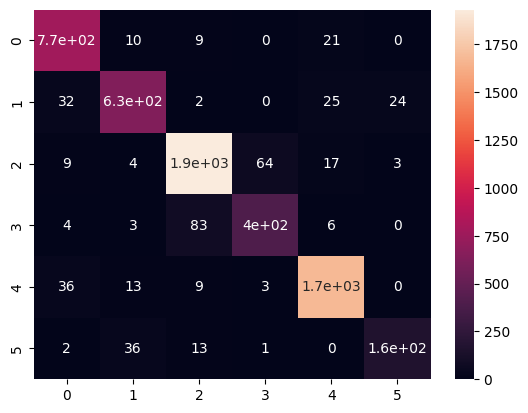

In [50]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)